## 概要

本文讲解了pyorbbecsdk配置红外相机(或者说深度相机)参数的相关API。本质上红外的参数就是深度相机参数， 本文统一称之为深度相机参数。

## 通过上位机进行调参
在上位机界面，调整的参数，查询红外相机的各项参数。 
并且可以在上位机的右侧实时预览到不同参数下的深度图效果。依次打开红外图与深度图的预览开关。 

左侧的红外图上面布满了白色斑点，这个点点是红外投影仪主动投射到物体上的特征点。 理想情况下，斑点应该跟非斑点区域有足够的对比度， 红外画面整体不能过暗或者过亮。
![](./image/调整红外相机参数.png)

需要注意的是，在上位机界面调整的参数，掉电后并不会保存。通过SDK调用的时候，需要自己指定相机参数。
推荐的使用方法是，先通过上位机对相机参数进行调参，因为可以实时预览， 比较方便。 然后把配置参数记录下来，通过SDK调用的时候，再通过SDK提供的API接口配置为对应数值。 

> 注意事项: 在运行jupyter notebook测试脚本之前，记得将上位机关闭， 解除对相机设备的占用。

## 导入依赖

In [1]:
# 将pyorbbecsdk的动态链接库所在的文件夹，添加到Python Path
import sys
import os
import open3d as o3d
# 导入阿凯写的Orbbec工具库, 确保orbbec_utils.py跟你目前所执行的脚本在同一级目录下
from orbbecsdk_utils import *
# 添加Python Path
add_path_pyorbbecsdk()

# 导入pyorbbecsdk
from pyorbbecsdk import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import numpy as np
import cv2
import open3d as o3d
from matplotlib import pyplot as plt

import logging

# 获取logger实例
logger = logging.getLogger("OrbbecSDK Utils")
# 指定日志的最低输出级别
logger.setLevel(logging.ERROR)

## 初始化视频流

In [3]:
# 连接设备
ret, device = connect_device()
print(f"[INFO] 设备是否连接成功: {ret}")

# pipeline初始化
pipeline = init_pipeline(device)
# 清空缓冲区
empty_cache(pipeline)

# 获取pipeline的相机参数
camera_param = pipeline.get_camera_param()

[05/25 00:09:04.143287][info][65087][Context.cpp:68] Context created with config: default config!
[05/25 00:09:04.143303][info][65087][Context.cpp:73] Work directory=/home/kyle/Project/奥比中光3D相机/Gemini2-软件资料-阿凯爱玩机器人/02.奥比中光-pyobbecsdk示例代码, SDK version=v1.10.5-20240511-7dc8be9
[05/25 00:09:04.143331][info][65087][LinuxPal.cpp:31] createObPal: create LinuxPal!
[05/25 00:09:04.212135][info][65087][LinuxPal.cpp:142] Create PollingDeviceWatcher!
[05/25 00:09:04.212171][info][65087][DeviceManager.cpp:15] Current found device(s): (1)
[05/25 00:09:04.212176][info][65087][DeviceManager.cpp:24] 	- Name: Orbbec Gemini 335, PID: 0x0800, SN/ID: CP1L44P00049, Connection: USB3.2
[INFO] 设备是否连接成功: True
[05/25 00:09:04.691823][error][65087][HostProtocol.cpp:420] Set property value failed! propertyId:63, rc:{statusCode: 9, respErrorCode: 2, msg: }
[05/25 00:09:04.692129][error][65087][HostProtocol.cpp:420] Set property value failed! propertyId:63, rc:{statusCode: 9, respErrorCode: 2, msg: }


## 工具函数

In [4]:
def preview_depth():
    '''预览深度图'''
    # 多采集几次, 清除缓存让配置生效
    for i in range(30):
        ret, color_img, depth_img = capture(pipeline)

    plt.imshow(depth_img)

In [5]:
def preview_pcd():
    '''预览PCD点云数据'''
    # 多采集几次, 清除缓存让配置生效
    for i in range(30):
        ret, color_img, depth_img = capture(pipeline)    
    # 获取Open3D PCD格式的点云
    pcd = create_point_cloud(color_img, depth_img, camera_param)
    # 点云可视化
    o3d.visualization.draw_geometries([pcd])
    return pcd

In [6]:
def print_camera_param_info(device, prop_id):
    '''打印相机参数信息'''
    # 查询当前参数
    cur_value = device.get_int_property(prop_id)
    print(f"当前的参数配置为: {cur_value}")
    # 查询白平衡的取值范围
    value_range = device.get_int_property_range(prop_id)
    print(f"数值范围: 最小值 {value_range.min} | 最大值 {value_range.max}")

## 曝光

### 手动曝光

In [7]:
# 手动曝光需要先将自动曝光开关关闭
device.set_bool_property(OBPropertyID.OB_PROP_DEPTH_AUTO_EXPOSURE_BOOL, False)

In [8]:
# 查询当前的曝光值，与有效数值范围
print_camera_param_info(device, OBPropertyID.OB_PROP_DEPTH_EXPOSURE_INT)

当前的参数配置为: 3000
数值范围: 最小值 1 | 最大值 165000


In [9]:
# 手动设置曝光值
device.set_int_property(OBPropertyID.OB_PROP_DEPTH_EXPOSURE_INT, 3000)

### 自动曝光

In [10]:
# 自动曝光开关开启
device.set_bool_property(OBPropertyID.OB_PROP_DEPTH_AUTO_EXPOSURE_BOOL, True)

In [11]:
# 查询自动曝光是否开启
device.get_bool_property(OBPropertyID.OB_PROP_DEPTH_AUTO_EXPOSURE_BOOL)

True

## 增益

> 注意事项: 在自动曝光模式下， 手动设置增益是无效的。 

In [12]:
# 查询当前的增益，与有效数值范围
print_camera_param_info(device, OBPropertyID.OB_PROP_DEPTH_GAIN_INT)

当前的参数配置为: 3000
数值范围: 最小值 16 | 最大值 248


In [13]:
# 手动设置增益值
device.set_int_property(OBPropertyID.OB_PROP_DEPTH_GAIN_INT, 3000)

## 深度工作模式


In [14]:
# 获取工作模式列表
mode_list = device.get_depth_work_mode_list()

In [15]:
mode_num = mode_list.get_count()
print(f"工作模式个数: {mode_num}")

工作模式个数: 6


In [16]:
# 设置高精度模式
mode = mode_list.get_depth_work_mode_by_index(2)
print("模式名称: ")
print(mode)

print("数据类型")
print(type(mode))

模式名称: 
High Accuracy
数据类型
<class 'pyorbbecsdk.OBDepthWorkMode'>


In [17]:
for i in range(mode_num):
    mode_name = mode_list.get_name_by_index(i)
    print(f"序号[{i}] 名称: {mode_name}")

序号[0] 名称: Default
序号[1] 名称: Hand
序号[2] 名称: High Accuracy
序号[3] 名称: High Density
序号[4] 名称: Medium Density
序号[5] 名称: Factory Calib


需要注意的是深度相机工作模式必须要在数据流开启之前进行配置。或者暂停当前的数据流， 配置后重新开启。 

In [18]:
# 中止当前的数据流
pipeline.stop()

# 关闭数据流后要等待一段时间，才可以
time.sleep(1)

# 设置深度工作模式
device.set_depth_work_mode(mode)


# 配置深度工作模式
time.sleep(1)

In [19]:
# 重新开启数据流
pipeline.start()

[05/25 00:09:26.491363][error][65087][HostProtocol.cpp:420] Set property value failed! propertyId:63, rc:{statusCode: 9, respErrorCode: 2, msg: }
[05/25 00:09:26.491654][error][65087][HostProtocol.cpp:420] Set property value failed! propertyId:63, rc:{statusCode: 9, respErrorCode: 2, msg: }


In [ ]:
> TODO 是哪个参数配置失败了?

## 预览深度图

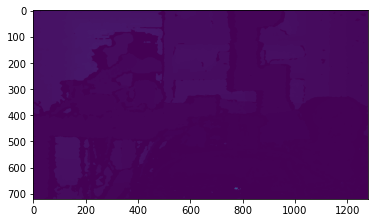

In [20]:
preview_depth()